# Trajectories analysis 2 (fish bouts analysis)
This notebook shows different analysis routines for trajectories of groups extracted with [idtracker.ai](idtracker.ai). If you use this code and/or data generated with [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., Nature Methods, 2019. idtracker.ai: tracking all individuals in small or large collectives of unmarked animals (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**


To load and analyse the trajectories we will be using the python library *trajectorytools*, you can install with `pip install trajectorytools`. If you use it, please cite:

**Heras, F. J. H., Romero-Ferrero, F., Hinz, R. C., & de Polavieja, G. G. (2019). Deep attention networks reveal the rules of collective motion in zebrafish. PLoS computational biology, 15(9), e1007354.**

## Importing necessary python modules for our analysis

In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

# trajectorytools needs to be installed. To install,
# pip install trajectorytools or follow the instructions at
# https://gitlab.com/polavieja_lab/trajectorytools
import trajectorytools as tt

## Load trajectories and setting parameters

Check the notebook T0_loading_idtrackerai_trajectories for more detailed instructions about loading idtracker.ai trajectories.

Note that in this case we are using the class FishTrajectories, as we are computing particular features of the fish movements.

In [2]:
# Set path where to load trajectories from
trajectories_path = "../data/test_trajectories.npy"
tr = tt.FishTrajectories.from_idtrackerai(
    trajectories_path, interpolate_nans=True, smooth_params={"sigma": 1}
)
# Since the arena of the setup was circular and the fish visited the borders of the arena
# we use the estimate_center_and_radius_from_locations to center the trajectories
# in the arena
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.origin_to(center)
# In our case we know that the body_length_px is a good estimate for the body length
# since we loaded the trajectories with the method from_idtrackerai this value is
# stored in the tr.params disctionary
tr.new_length_unit(tr.params["body_length_px"], "BL")
tr.new_time_unit(tr.params["frame_rate"], "s")
# Since we loaded the trajectories with the method from_idtrackerai we can
# use the frame_rate variable stored in the tr.params disctioanry to
# to set the time units to seconds
print("Positions array shape ", tr.s.shape)
print("Velocities array shape ", tr.v.shape)
print("Accelerations array shape ", tr.a.shape)
print("Positions:")
print(
    "X range:",
    np.nanmin(tr.s[..., 0]),
    np.nanmax(tr.s[..., 0]),
    f"{tr.params['length_unit_name']}",
)
print(
    "Y range:",
    np.nanmin(tr.s[..., 1]),
    np.nanmax(tr.s[..., 1]),
    f"{tr.params['length_unit_name']}",
)
print("Velcities:")
print(
    "X range:",
    np.nanmin(tr.v[..., 0]),
    np.nanmax(tr.v[..., 0]),
    f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}",
)
print(
    "Y range:",
    np.nanmin(tr.v[..., 1]),
    np.nanmax(tr.v[..., 1]),
    f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}",
)
print("Accelerations:")
print(
    "X range:",
    np.nanmin(tr.a[..., 0]),
    np.nanmax(tr.a[..., 0]),
    f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2",
)
print(
    "Y range:",
    np.nanmin(tr.a[..., 1]),
    np.nanmax(tr.a[..., 1]),
    f"{tr.params['length_unit_name']}/{tr.params['time_unit_name']}^2",
)
pprint(tr.params)

Positions array shape  (28817, 4, 2)
Velocities array shape  (28817, 4, 2)
Accelerations array shape  (28817, 4, 2)
Positions:
X range: -22.857960805634484 23.004886491518306 BL
Y range: -23.15551579252565 23.09623793320273 BL
Velcities:
X range: -24.308591158867152 25.440020858505456 BL/s
Y range: -27.244428384301894 21.108243189033033 BL/s
Accelerations:
X range: -580.2747863777576 1202.8359590531866 BL/s^2
Y range: -375.60146057076224 346.45476781825226 BL/s^2
{'_center': array([1782.57651696, 1761.71033149]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.57651696, -1761.71033149]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 69.0,
 'length_unit_name': 'BL',
 'path': '../data/test_trajectories.npy',
 'radius': 23.18884521417357,
 'radius_px': 1600.0303197779763,
 'smooth_params': {'sigma': 1},
 'time_unit': 32,
 'time_unit_name': 's'}


## Bouts detector

In [3]:
all_bouts = tr.get_bouts(
    find_min_dict={"prominence": (0.01, None), "distance": 6},
    find_max_dict={"prominence": (0.01, None), "distance": 6},
)

In [15]:
%matplotlib inline
from ipywidgets import interactive


def plot_slide_time(t, focal):
    fig, ax = plt.subplots(3, figsize=(20, 5), sharex=True)
    time_range = (t, t + 10)  # in seconds
    frame_range = np.arange(
        time_range[0] * tr.params["frame_rate"],
        time_range[1] * tr.params["frame_rate"],
        1,
    )

    starting_bouts = all_bouts[focal][:, 0][
        np.where(
            (all_bouts[focal][:, 0] > frame_range[0])
            & ((all_bouts[focal][:, 0] < frame_range[-1]))
        )
    ]
    bout_peaks = all_bouts[focal][:, 1][
        np.where(
            (all_bouts[focal][:, 1] > frame_range[0])
            & ((all_bouts[focal][:, 1] < frame_range[-1]))
        )
    ]
    ax[0].plot(
        frame_range / tr.params["frame_rate"], tr.speed[frame_range, focal], c="b"
    )
    ax[1].plot(
        frame_range / tr.params["frame_rate"],
        tr.acceleration[frame_range, focal],
        c="b",
    )
    ax[2].plot(
        frame_range / tr.params["frame_rate"], tr.curvature[frame_range, focal], c="b"
    )
    for starting_bout in starting_bouts:
        for i in range(3):
            ax[i].axvline(x=starting_bout / tr.params["frame_rate"], c="g")
    for bout_peak in bout_peaks:
        for i in range(3):
            ax[i].axvline(x=bout_peak / tr.params["frame_rate"], c="r")

    ax[0].set(ylabel="Speed (BL/s)", ylim=(0, None))
    ax[1].set(ylabel="Acceleration ($BL/s^2$)", ylim=(0, None))
    ax[2].set(xlabel="t (s)", ylabel="Curvature (1/BL)", ylim=(-3, 3))
    fig.subplots_adjust()


interactive_plot = interactive(
    plot_slide_time,
    t=(0, tr.number_of_frames // tr.params["frame_rate"]),
    focal=(0, tr.number_of_individuals - 1, 1),
)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=450, description='t', max=900), IntSlider(value=1, description='focal', …

In [18]:
t = 0
focal = 0
time_range = (t, t + 10)  # in seconds
frame_range = range(
    time_range[0] * tr.params["frame_rate"], time_range[1] * tr.params["frame_rate"], 1
)
starting_bouts = all_bouts[focal][:, 0][
    np.where(
        (all_bouts[focal][:, 0] > frame_range[0])
        & ((all_bouts[focal][:, 0] < frame_range[-1]))
    )
]
bout_peaks = all_bouts[focal][:, 1][
    np.where(
        (all_bouts[focal][:, 1] > frame_range[0])
        & ((all_bouts[focal][:, 1] < frame_range[-1]))
    )
]
print(starting_bouts)

[ 17  31  52  65  81  90  98 106 116 128 138 156 164 171 182 190 200 209
 219 231 243 251 263 275 282 288 296 305 313]


Number of bouts in 15.01 minutes:
Number of bouts per animal:  [2699, 2362, 2248, 2529]


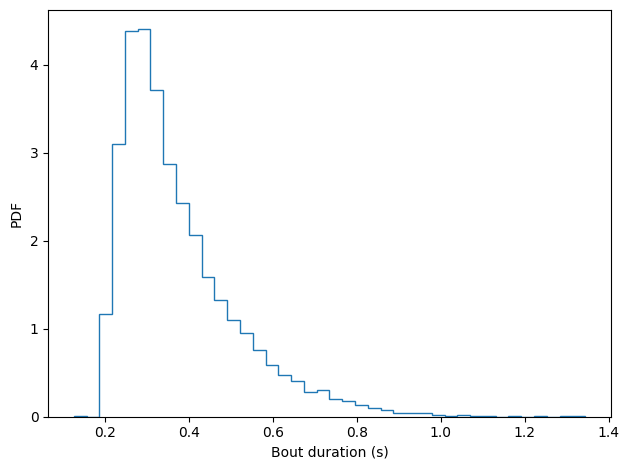

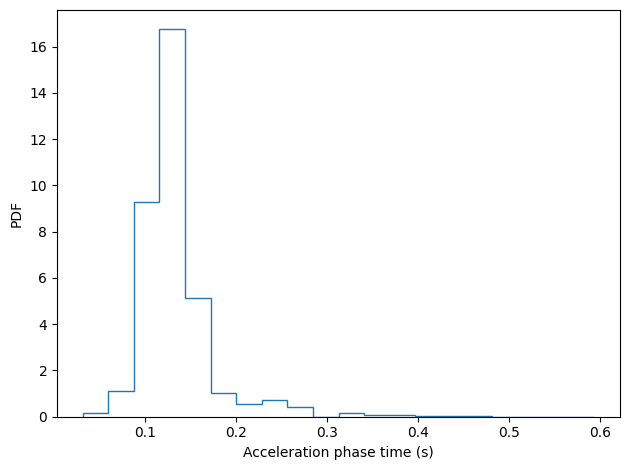

In [25]:
print(
    f"Number of bouts in {tr.number_of_frames / tr.params['frame_rate'] / 60:.2f} minutes:"
)
print("Number of bouts per animal: ", [(len(indiv_bouts)) for indiv_bouts in all_bouts])

bout_latency = np.hstack(
    [
        (indiv_bouts[:, 2] - indiv_bouts[:, 0]) / tr.params["frame_rate"]
        for indiv_bouts in all_bouts
    ]
)
fig, ax = plt.subplots()
ax.hist(bout_latency, bins=40, density=True, histtype="step", align="mid")
ax.set(xlabel="Bout duration (s)", ylabel="PDF")
fig.tight_layout()


bout_duration_acc = np.hstack(
    [
        (indiv_bouts[:, 1] - indiv_bouts[:, 0]) / tr.params["frame_rate"]
        for indiv_bouts in all_bouts
    ]
)

fig, ax = plt.subplots()
ax.hist(bout_duration_acc, bins=20, density=True, histtype="step", align="mid")
ax.set(xlabel="Acceleration phase time (s)", ylabel="PDF")
fig.tight_layout()

In [27]:
speeds_at_bout_start = [
    tr.speed[focal_bout[0], focal]
    for focal, focal_bouts in enumerate(all_bouts)
    for focal_bout in focal_bouts
]
speeds_at_bout_peak = [
    tr.speed[focal_bout[1], focal]
    for focal, focal_bouts in enumerate(all_bouts)
    for focal_bout in focal_bouts
]
speed_change_in_bout = np.hstack(
    [
        (tr.speed[focal_bouts[:, 1], focal] - tr.speed[focal_bouts[:, 0], focal])
        for focal, focal_bouts in enumerate(all_bouts)
    ]
)

In [30]:
fig, ax = plt.subplots()
ax.hist(
    speeds_at_bout_start,
    bins=np.arange(0, 20, 0.1),
    density=True,
    histtype="step",
    align="mid",
    label="bout start",
)
ax.hist(
    speeds_at_bout_peak,
    bins=np.arange(0, 20, 0.1),
    density=True,
    histtype="step",
    align="mid",
    label="bout peak",
)
ax.hist(
    speed_change_in_bout,
    bins=np.arange(0, 20, 0.1),
    density=True,
    histtype="step",
    align="mid",
    label="peak-start",
)
ax.set(xlabel="Speed (BL/s)", ylabel="PDF")
ax.legend()